reading, storing, and plotting data

In [287]:
import matplotlib.pyplot as plt
import random as rnd
from math import dist

# ----- read and clean datapoints -----
def generate_data_from_file():

    file_path = "assets/datapoints.txt"

    with open(file_path, "r") as file_r:
        datapoints = [row.strip("\n").split(", ") for row in file_r] # split each row into a list of 3 elements, remove newlines, and store list as element in datapoints list
        datapoints.remove(datapoints[0]) # remove column header
        datapoints = [[float(element) for element in point] for point in datapoints]

    data = { # dictionary containing all pokemon, and their width/height measurements
        "pikachu" : {
        "width"   : [i[0] for i in datapoints if i[2] == 1],
        "height"  : [i[1] for i in datapoints if i[2] == 1]
        },
        "pichu"   : {
        "width"   : [i[0] for i in datapoints if i[2] == 0],
        "height"  : [i[1] for i in datapoints if i[2] == 0]
        }
    }

    return data

# ----- read and clean testpoints -----
def generate_test_data_from_file():

    file_path = "assets/testpoints.txt"

    with open(file_path, "r") as file_r:
        testpoints = [row[4:-2].split(", ") for row in file_r]
        testpoints.remove(testpoints[0])
        testpoints = [[float(element) for element in point] for point in testpoints]

    test_data = { # dictionary containing all undefined points, and their width/height measurements
        "undefined" : {
        "width"   : [i[0] for i in testpoints],
        "height"  : [i[1] for i in testpoints]
        }
    }

    return test_data
        
# ----- plot data from data (and test data) -----
def plot_data(data, test_data = 0):

    # TODO: add option to plot incorrect results from accuracy function in a different color to show which points were incorrectly categorized

    # ----- plot pikachu and pichu datapoints -----
    plt.scatter(data["pikachu"]["width"],  data["pikachu"]["height"], color = "orange", label = "Pikachus")
    plt.scatter(data["pichu"]["width"],    data["pichu"]["height"],   color = "red",  label = "Pichus")

    if test_data != 0: # if test data was added as input parameter:
        if "undefined" in test_data: # plot undefined unknown points
            plt.scatter(test_data["undefined"]["width"],  test_data["undefined"]["height"], color = "blue", label = "Undefined")
        if "pikachu" in test_data: # plot undefined pikachus
            plt.scatter(test_data["pikachu"]["width"],  test_data["pikachu"]["height"], color = "black", label = "Undefined (Pikachu)")
        if "pichu" in test_data: # plot undefined pichus
            plt.scatter(test_data["pichu"]["width"],  test_data["pichu"]["height"], color = "blue", label = "Undefined (Pichu)")

    plt.title("Scatterplot of width / height measurements of pokemon")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.legend();

# ----- format and error handle user input -----
def clean_user_input():
    while True:
        user_input = input("Enter a manual point to categorize, formatted like 'width, height' (x, y):\n(Optionally enter a third number for amount of votes, default: 1)")
        try:
            user_input = user_input.split(",")
            user_input = [float(i.strip()) for i in user_input] # remove empty space
            valid_input = True

            for i in user_input:
                if i <= 0:
                    print(f"'{i}' is not a valid input, make sure to enter positive numbers only")
                    valid_input = False

            if valid_input == True:
                width = user_input[0]
                height = user_input[1]
                if len(user_input) >= 3: # if user entered a third number
                    amount_votes = int(user_input[2]) # set majority vote
                else:
                    amount_votes = 1 # majority vote defaults to 1
                
                return width, height, amount_votes

            
        except ValueError as err:
            print(f"{err} is not a valid point, make sure to enter 2-3 positive numbers")

# ----- categorize specific point compared to data, based off majority vote on euclidean distance -----
def categorize_point(point, data, amount_votes = 1):

    distance_list = []

    for i in range(len(data["pikachu"]["width"])): # calculate distance between all pikachu / pichu points and (x, y), and store them in distance
        distance_list.append([dist((data["pikachu"]["width"][i], data["pikachu"]["height"][i]), (point[0], point[1])), "pikachu"])
        distance_list.append([dist((data["pichu"]["width"][i], data["pichu"]["height"][i]), (point[0], point[1])), "pichu"])

    distance_list.sort() # sort distance, this sorts on the first index of lists in distance list, and keeps the pokemon tag

    del distance_list[amount_votes::] # remove indices of distance outside the votes specified to be taken into consideration

    category = ""
    certainty = 0

    distance_pikachu = [distance[0] for distance in distance_list if distance[1] == "pikachu"]
    distance_pichu = [distance[0] for distance in distance_list if distance[1] == "pichu"]

    # ----- return most category represented in distance measurements -----
    if len(distance_pikachu) > len(distance_pichu):
        category = "pikachu"
        certainty = len(distance_pikachu) / (len(distance_pikachu) + len(distance_pichu))
        return category, certainty
    elif len(distance_pichu) > len(distance_pikachu):
        category = "pichu"
        certainty = len(distance_pichu) / (len(distance_pikachu) + len(distance_pichu))
        return category, certainty

    # ----- if distance measurements of different categories is equally represented -----
    if len(distance_pikachu) == len(distance_pichu):

        # ----- calculate weighted distance (smaller is better) -----
        weighted_distance_pikachu = sum(distance_pikachu) / len(distance_pikachu)
        weighted_distance_pichu = sum(distance_pichu) / len(distance_pichu)

        # ----- return smallest weighted distance to point -----
        if weighted_distance_pikachu < weighted_distance_pichu: 
            category = "pikachu"
            certainty = weighted_distance_pichu / (weighted_distance_pikachu + weighted_distance_pichu)
            return category, certainty
        else:
            category = "pichu"
            certainty = weighted_distance_pikachu / (weighted_distance_pichu + weighted_distance_pikachu)
            return category, certainty

# ----- randomly split data into test and training data -----
def generate_test_training_data(data):

    test_data       = {"pikachu" : {"width" : [], "height" : []}, "pichu" : {"width" : [], "height" : []}}
    training_data   = {"pikachu" : {"width" : [], "height" : []}, "pichu" : {"width" : [], "height" : []}}

    # ----- randomly splitting pikachus into test and training groups -----
    random_point_pikachu = rnd.sample(range(0, 75), 25)
    test_data["pikachu"]["width"] = [data["pikachu"]["width"][i] for i in random_point_pikachu]
    test_data["pikachu"]["height"] = [data["pikachu"]["height"][i] for i in random_point_pikachu]

    training_data["pikachu"]["width"] = [data["pikachu"]["width"][i] for i in range(75) if i not in random_point_pikachu]
    training_data["pikachu"]["height"] = [data["pikachu"]["height"][i] for i in range(75) if i not in random_point_pikachu]

    # ----- randomly splitting pichus into test and training groups -----
    random_point_pichu = rnd.sample(range(0, 75), 25) # second random here for pichu randoms
    test_data["pichu"]["width"] = [data["pichu"]["width"][i] for i in random_point_pichu]
    test_data["pichu"]["height"] = [data["pichu"]["height"][i] for i in random_point_pichu]

    training_data["pichu"]["width"] = [data["pichu"]["width"][i] for i in range(75) if i not in random_point_pichu]
    training_data["pichu"]["height"] = [data["pichu"]["height"][i] for i in range(75) if i not in random_point_pichu]

    # NOTE: use to check that no same point is picked twice:
    # print(f"Random Point: {random_point_pikachu}")
    # print(f"Not random: {[i for i in range(75) if i not in random_point_pikachu]}")

    return test_data, training_data # to use in functions

# ----- calculate accuracy of calculations by comparing generated test and training data -----
def calculate_accuracy(test_data, data, amount_votes = 1):

    TP, TN, FP, FN = 0, 0, 0, 0

    for i in range(len(test_data["pikachu"]["width"])):

        res = categorize_point([test_data["pikachu"]["width"][i], test_data["pikachu"]["height"][i]], data,  amount_votes)
        #if "pikachu" in res:
        if res[0] == "pikachu":
            TP += 1
        else:
            FP += 1
        
        res = categorize_point([test_data["pichu"]["width"][i], test_data["pichu"]["height"][i]], data,  amount_votes)
        #if "pichu" in res:
        if res[0] == "pichu":
            TN += 1
        else:
            FN += 1
    print(TP, TN, FP, FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    return accuracy


In [63]:
# TODO complete comments and describe functions
# TODO add option to input incorrect accuracy points in plot function

In [244]:
data = generate_data_from_file() # read in datapoints file and store as data
test_data, training_data = generate_test_training_data(data) # split datapoints in data randomly into 2 groups; test and training data

accuracy = calculate_accuracy(test_data, training_data, 10) # categorize points of test data compared to training data, and calculate accuracy of predictions
print(accuracy) # print accuracy results

23 24 2 1
0.94


## Read, clean, and store data from files

In [284]:
data = generate_data_from_file()
test_data = generate_test_data_from_file()

## Plot datapoints, and test points (optional)

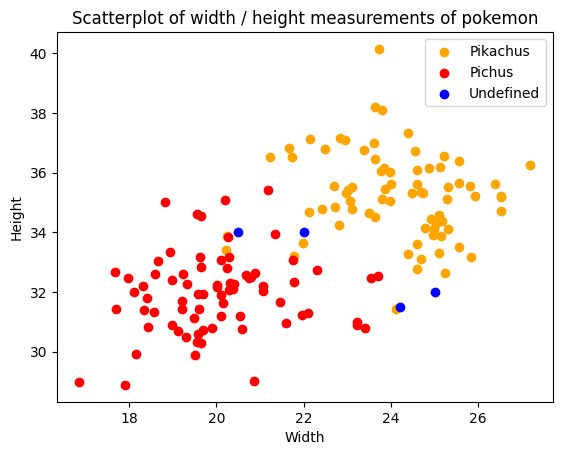

In [288]:
data = generate_data_from_file()
test_data = generate_test_data_from_file()

#plot_data(data) # plot datapoints
plot_data(data, test_data) # NOTE: can also plot unclassified datapoints

## Calculate distance and categorize test point

Majority vote of n:

In [248]:
data = generate_data_from_file()
test_data = generate_test_data_from_file()

for point in range(len(test_data["undefined"]["width"])):
    amount_votes = 10 # set this to any number of majority votes
    result = categorize_point([test_data["undefined"]["width"][point], test_data["undefined"]["height"][point]], data, amount_votes)
    print(f'Point {test_data["undefined"]["width"][point], test_data["undefined"]["height"][point]} calculated as "{result[0].capitalize()}"')
    print(f"({result[1] * 100:.1f}% certainty based on a majority vote of {amount_votes})\n")

Point (25.0, 32.0) calculated as "Pikachu"
(80.0% certainty based on a majority vote of 10)

Point (24.2, 31.5) calculated as "Pichu"
(53.4% certainty based on a majority vote of 10)

Point (22.0, 34.0) calculated as "Pikachu"
(70.0% certainty based on a majority vote of 10)

Point (20.5, 34.0) calculated as "Pichu"
(80.0% certainty based on a majority vote of 10)



## Manually input point to categorize

In [249]:
data = generate_data_from_file()

user_input = clean_user_input()
result = categorize_point([user_input[0], user_input[1]], data, user_input[2])
print(f"Width, height {user_input[0], user_input[1]} calculated as '{result[0]}' with {result[1] * 100:.1f}% certainty (based on a majority vote of {user_input[2]})")

32.5, 23.4, 10
Width, height (32.5, 23.4) calculated as 'pikachu' with 70.0% certainty (based on a majority vote of 10)


## Randomly split original data into new test and training data

24 25 1 0
Accuracy of categorization: 98.0%


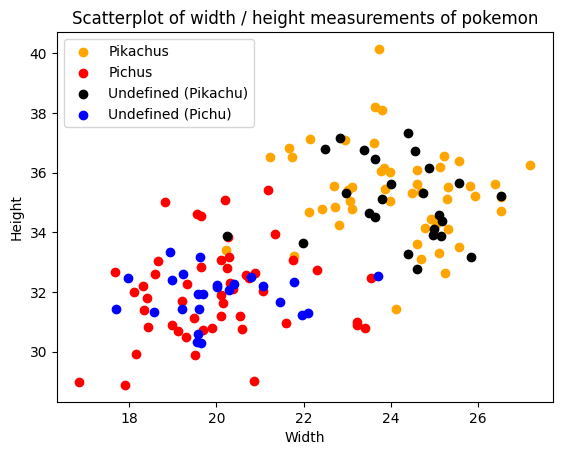

In [294]:
data = generate_data_from_file() # read in datapoints file and store as data
test_data, training_data = generate_test_training_data(data) # split datapoints in data randomly into 2 groups; test and training data

plot_data(training_data, test_data)

accuracy = calculate_accuracy(test_data, training_data, 10) # categorize points of test data compared to training data, and calculate accuracy of predictions
print(f"Accuracy of categorization: {accuracy * 100}%") # print accuracy results # TODO return TP TN FP FN

## Plot accuracy of multiple sets of test and training data

Randomly split data into test and training data  
Calculate accuracy of test data categorization compared to training data  
Graph calculated accuracy  
Calculate average accuracy of multiple sets of simulations  

23 25 2 0
0.96
22 24 3 1
0.92
24 25 1 0
0.98
24 25 1 0
0.98
24 23 1 2
0.94
24 24 1 1
0.96
23 24 2 1
0.94
24 23 1 2
0.94
23 24 2 1
0.94
23 25 2 0
0.96
Average: 0.952


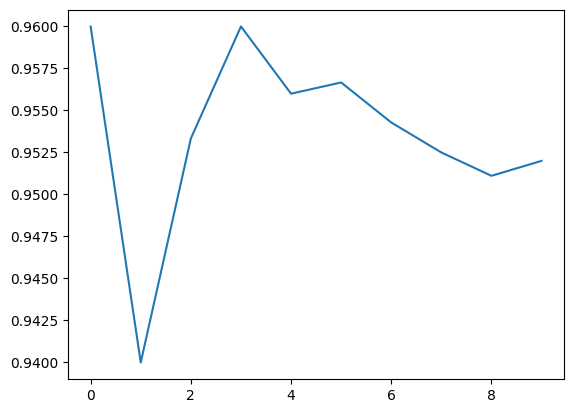

In [298]:
accuracy_list = []
average_accuracy_list = []

for i in range(10):
    data = generate_data_from_file() # read in datapoints file and store as data
    test_data, training_data = generate_test_training_data(data) # split datapoints in data randomly into 2 groups; test and training data


    accuracy = calculate_accuracy(test_data, training_data, 10) # categorize points of test data compared to training data, and calculate accuracy of predictions
    accuracy_list.append(accuracy)
    # average_accuracy_list.append(sum(accuracy_list) / len(accuracy_list)) # NOTE also display average accuracy accumulated over n simulations?
    print(accuracy) # print accuracy results # TODO return TP TN FP FN

plt.plot(accuracy_list)

average_accuracy = sum(accuracy_list) / len(accuracy_list)
print(f"Average: {average_accuracy}")